In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

In [41]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_info_columns', 10_000)   # zeigt alle Spaltennamen in info()
pd.set_option('display.max_info_rows', 200_000)     # zeigt Zeileninfo, wenn nötig


# Pfad zur Datei (liegt im gleichen Ordner wie das Notebook)
path = Path("dataset/311_Service_Requests_2024.csv")

# Einfacher Import
df = pd.read_csv(path)


In [42]:
# Anzahl Einträge von Jahr 2024
df['CREATED_DATE'] = pd.to_datetime(df['CREATED_DATE'], errors='coerce')

year_counts = df['CREATED_DATE'].dt.year.value_counts().sort_index()

print(year_counts.loc[2024], "Einträge im Jahr 2024")

1913929 Einträge im Jahr 2024


In [43]:
# Bearbeitungszeit
df["CREATED_DATE"] = pd.to_datetime(df["CREATED_DATE"], errors="coerce")
df["CLOSED_DATE"] = pd.to_datetime(df["CLOSED_DATE"], errors="coerce")

# Response Time in Tagen (alternativ in Stunden)
df["response_time"] = (df["CLOSED_DATE"] - df["CREATED_DATE"]).dt.total_seconds() / (60*60*24)

In [44]:
# Vergleich Bearbeitungszeits mit Status

df["STATUS"].unique()

erledigt = df[df["STATUS"] == "completed"].copy()
offen = df[df["STATUS"] == "open"].copy()
abgebrochen = df[df["STATUS"] == "canceled"].copy()

# Datumsfelder automatisch umwandeln
erledigt["CREATED_DATE"] = pd.to_datetime(erledigt["CREATED_DATE"], errors="coerce")
erledigt["CLOSED_DATE"] = pd.to_datetime(erledigt["CLOSED_DATE"], errors="coerce")

# Bearbeitungszeit in Tagen berechnen
erledigt["response_time"] = (
    erledigt["CLOSED_DATE"] - erledigt["CREATED_DATE"]
).dt.total_seconds() / (60 * 60 * 24)

# Nur sinnvolle Werte behalten (nicht negativ, nicht leer)
erledigt = erledigt[erledigt["response_time"].notna() & (erledigt["response_time"] >= 0)]

# Übersichtstabelle erstellen
overview = pd.DataFrame({
    "Status": ["Erledigt", "Offen", "Abgebrochen"],
    "Anzahl": [len(erledigt), len(offen), len(abgebrochen)],
    "Median (Tage)": [erledigt["response_time"].median(), np.nan, np.nan],
    "75%-Quantil (Tage)": [erledigt["response_time"].quantile(0.75), np.nan, np.nan],
    "Max. Bearbeitungszeit (Tage)": [erledigt["response_time"].max(), np.nan, np.nan]
})

print("\n Übersicht der Bearbeitungszeiten")
print(overview)



 Übersicht der Bearbeitungszeiten
        Status  Anzahl  Median (Tage)  75%-Quantil (Tage)  \
0     Erledigt       0            NaN                 NaN   
1        Offen       0            NaN                 NaN   
2  Abgebrochen       0            NaN                 NaN   

   Max. Bearbeitungszeit (Tage)  
0                           NaN  
1                           NaN  
2                           NaN  


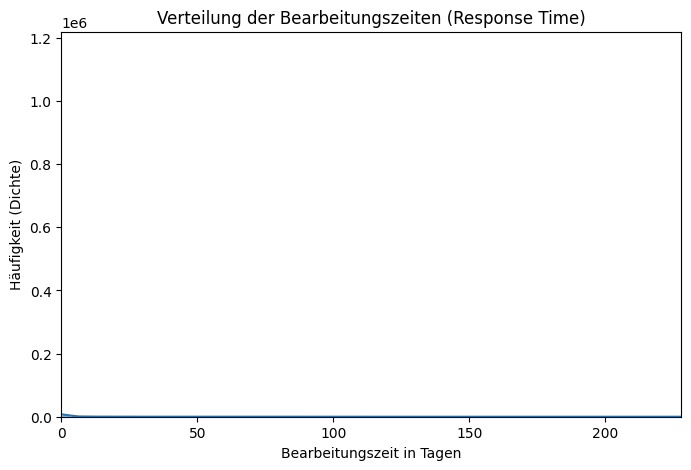

In [45]:
# Nur abgeschlossene Anfragen betrachten
df_response = df[df["response_time"].notna()]

# Ich habe gesehen dass dieser plot nicht geeignet ist, da der großteil der Aufgträge innerhalb von 0 bis 5 Tagen bearbeitet und abgeschlossen werden
plt.figure(figsize=(8,5))
sns.histplot(df_response["response_time"], bins="fd", kde=True)
plt.xlabel("Bearbeitungszeit in Tagen")
plt.ylabel("Häufigkeit (Dichte)")
plt.title("Verteilung der Bearbeitungszeiten (Response Time)")
plt.xlim(0, df_response["response_time"].quantile(0.99))  # optional, um extreme Ausreißer auszublenden
plt.show()

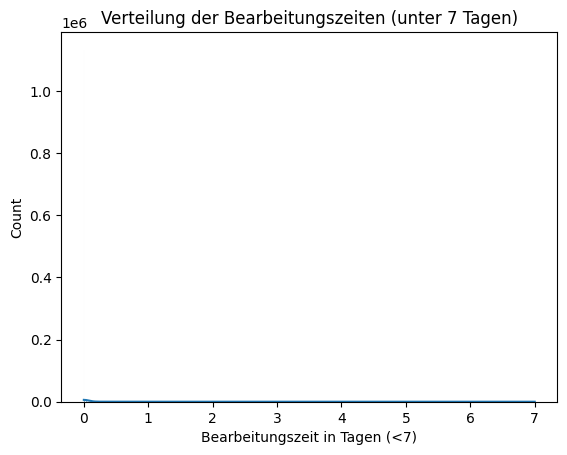

In [46]:
# Alternative Darstellung der Bearbeitungszeit 
subset = df_response[df_response["response_time"] < 7]  # z. B. max 30 Tage
sns.histplot(subset["response_time"], bins="fd", kde=True)
plt.xlabel("Bearbeitungszeit in Tagen (<7)")
plt.title("Verteilung der Bearbeitungszeiten (unter 7 Tagen)")
plt.show()


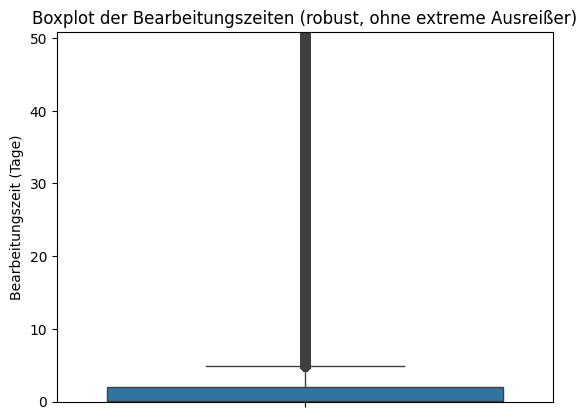

In [47]:
# Alternative Darstellung der Bearbeitungszeit 
sns.boxplot(y="response_time", data=df_response)
plt.ylim(0, df_response["response_time"].quantile(0.95))  # bis 95 %-Perzentil
plt.ylabel("Bearbeitungszeit (Tage)")
plt.title("Boxplot der Bearbeitungszeiten (robust, ohne extreme Ausreißer)")
plt.show()


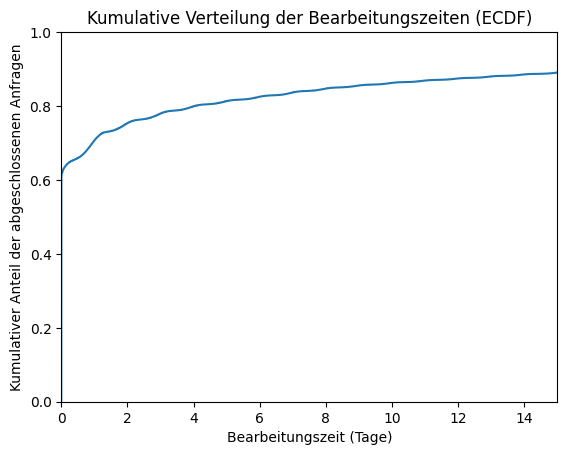

In [48]:
sns.ecdfplot(data=df_response, x="response_time")
plt.xlim(0, 15)
plt.xlabel("Bearbeitungszeit (Tage)")
plt.ylabel("Kumulativer Anteil der abgeschlossenen Anfragen")
plt.title("Kumulative Verteilung der Bearbeitungszeiten (ECDF)")
plt.show()


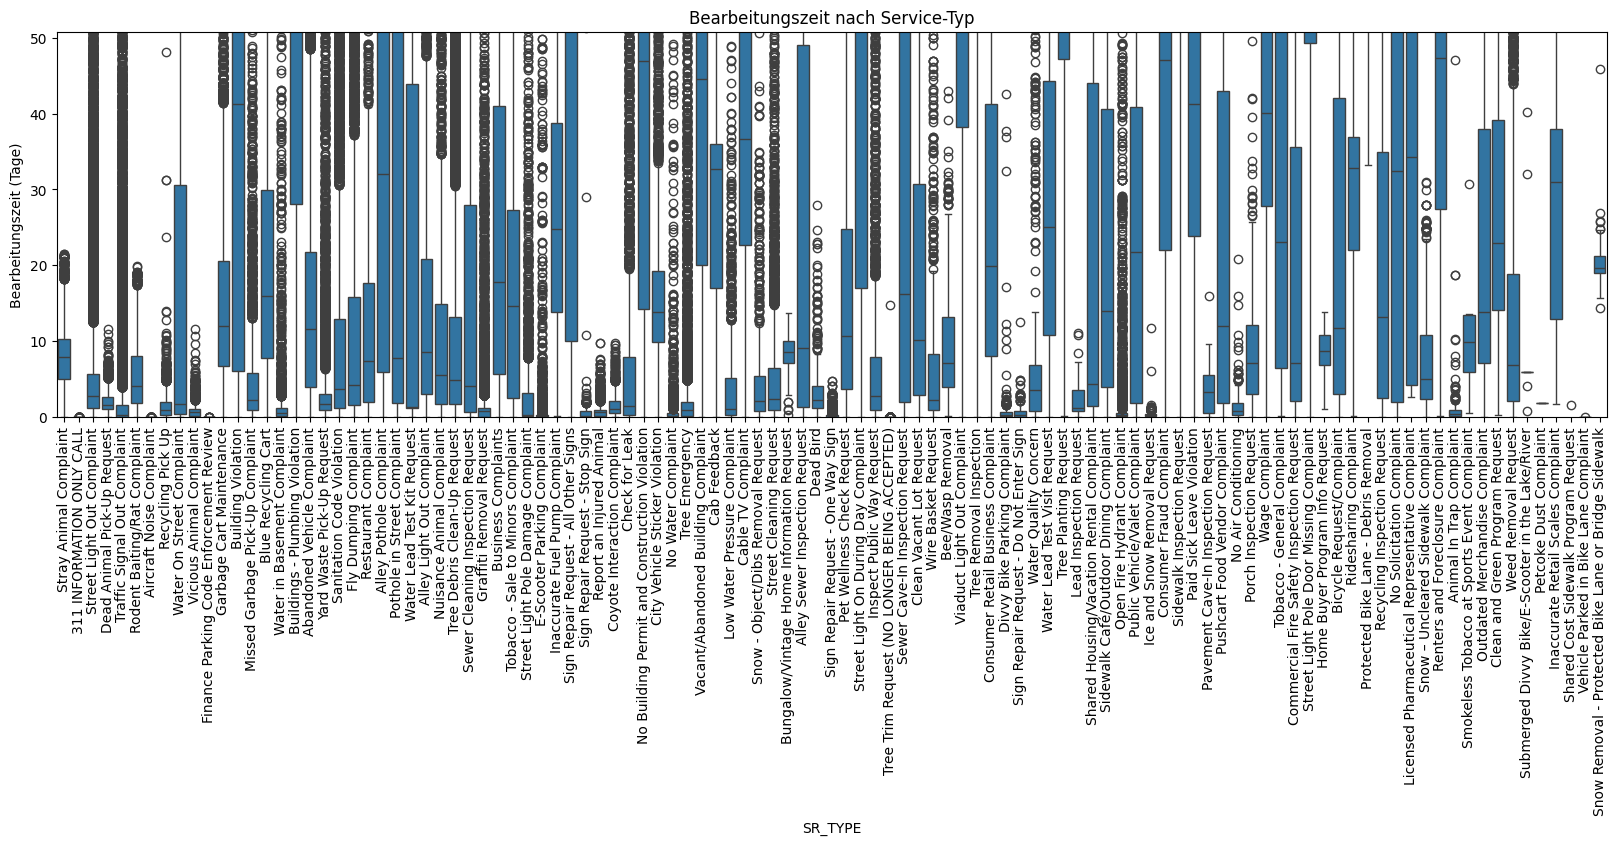

In [49]:
# Vergleich Bearbeitungszeit nach SR Type
plt.figure(figsize=(20,5))
sns.boxplot(x="SR_TYPE", y="response_time", data=df_response)
plt.xticks(rotation=90)
plt.ylabel("Bearbeitungszeit (Tage)")
plt.title("Bearbeitungszeit nach Service-Typ")
plt.ylim(0, df_response["response_time"].quantile(0.95))
plt.show()


<Axes: xlabel='CREATED_HOUR', ylabel='Proportion'>

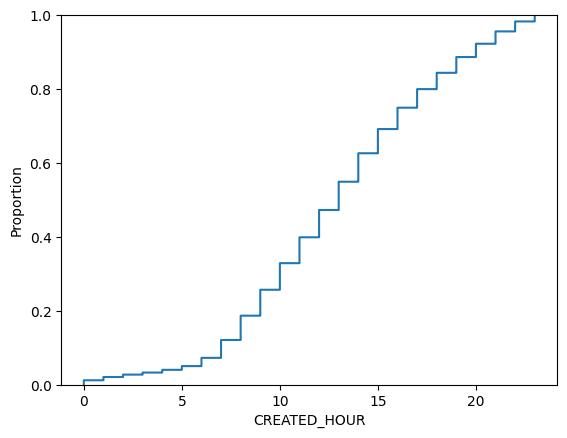

In [50]:
sns.ecdfplot(df, x="CREATED_HOUR")

In [52]:
# Latitude wo die Calls getätigt wurden geografisch
# Woher stammen die meisten Calls
# Zu welcher uhrzeit sind die Calls
# Welche art von complaints sind wo am meisten
